# Fidelity Analysis for First Order Trotter 
In this notebook I provide the scripts that allow me to analize the digital-analog  simulation of the interaction part of the Heiseneberg hamiltonian and compare it against its digital counterpart. I focus on developing the code for 1st order Trotter since the extension to higher orders is then a straightforward modification of the code.

TODO explain logic

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

MAX = 1e9

## Single Step Analysis
TODO explain logic

In [3]:
def fidelityDigitalT1(N, args):
    return (args["F_1q"] ** args["N1D"](N)) * (args["F_Uq"] ** args["NUq"](N)) * (args["F_zz"] ** args["Nzz"](N))

def fidelityDAnalogT1(N, args):
    return (args["F_1q"] ** args["N1DA"](N)) * (args["F_xy"](N) ** args["Nxy"])

def color_gradient(start, end, n):
    """Generate n hex colors from start to end."""
    start_rgb = np.array(mcolors.to_rgb(start))
    end_rgb = np.array(mcolors.to_rgb(end))
    return [mcolors.to_hex(start_rgb + (end_rgb - start_rgb) * i/(n-1)) for i in range(n)]

def fidelityEvaluatorT1(values_N, args):
    fid_dig = np.zeros(len(values_N))
    fid_dan = np.zeros(len(values_N))
    fid_ratio = np.zeros(len(values_N))

    for N in values_N:
        fid_dig[N-values_N[0]] = fidelityDigitalT1(N, args)
        fid_dan[N-values_N[0]] = fidelityDAnalogT1(N, args)
        fid_ratio[N-values_N[0]] = fid_dan[N-values_N[0]] / fid_dig[N-values_N[0]] # NOTE: I look for F_DA / F_D > 1 s.t. F_DA > F_D

    return fid_dig, fid_dan, fid_ratio

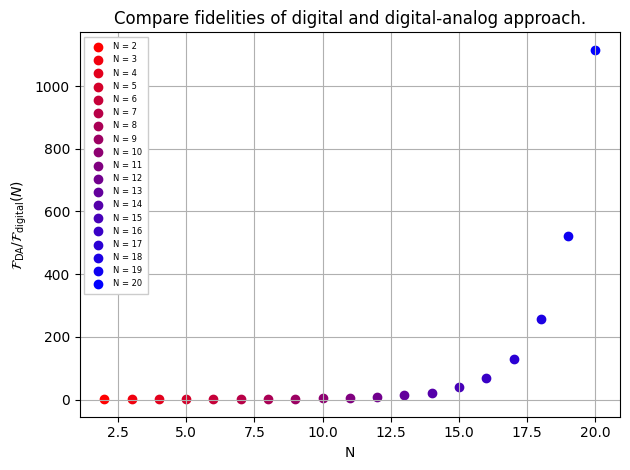

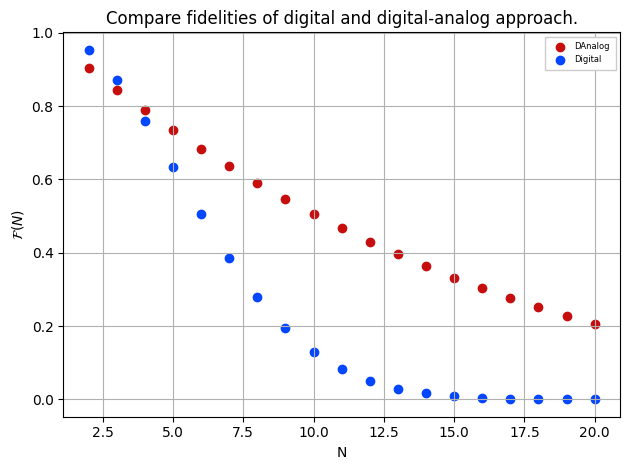

In [4]:
params = {
    # fidelities
    "F_1q": 1-1e-3, # fidelity of 1q rotations gates
    "F_Uq": 1-1e-3, # fidelity of Uq gates
    "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
    "F_xy": lambda N: 0.99 - 0.02*(N-1), # fidelity of analog XY gate
    # number of gates per single Trotter step
    "N1D" : lambda N: 3*N*(N-1)/2 + N,
    "N1DA": lambda N: 4*N + N,       
    "NUq" : lambda N: 6*N*(N-1),
    "Nzz" : lambda N: 3*N*(N-1)/2,
    "Nxy" : 3
}

N_max = 20
values_N = np.arange(2, N_max+1)

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(values_N))

for N in values_N:
    ax.scatter(N, fidelityDAnalogT1(N, params)/fidelityDigitalT1(N, params), color=colors[N-2], label=f"N = {N}")

ax.set_title("Compare fidelities of digital and digital-analog approach.")
ax.set_xlabel("N")
ax.set_ylabel(r"$\mathcal{F}_\text{DA}/\mathcal{F}_\text{digital} (N)$")

legend = ax.legend(loc=2, frameon=True, borderaxespad=0.8, fontsize=6)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle("Square")

plt.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", N_max-1)

fid_digital = np.zeros(len(values_N))
fid_danalog = np.zeros(len(values_N))

for N in values_N:
    fid_digital[N-2] = fidelityDigitalT1(N, params)
    fid_danalog[N-2] = fidelityDAnalogT1(N, params)

ax.scatter(values_N, fid_danalog, label="DAnalog", color="#C70E0E")
ax.scatter(values_N, fid_digital, label="Digital", color="#0346FF")

ax.set_title("Compare fidelities of digital and digital-analog approach.")
ax.set_xlabel("N")
ax.set_ylabel(r"$\mathcal{F}(N)$")

legend = ax.legend(loc=1, frameon=True, borderaxespad=0.8, fontsize=6)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle("Square")

plt.grid()
plt.tight_layout()
plt.show()

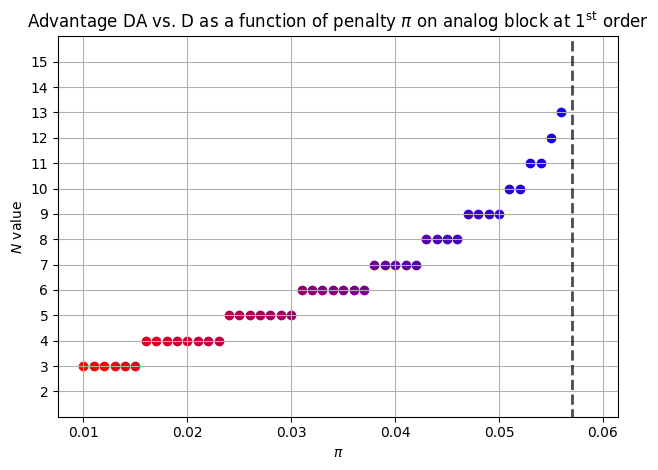

In [5]:
penalty_values = np.arange(10, 60) * 1e-3 

N_max = 15
values_N = np.arange(2, N_max+1)

if 0 in values_N or N_max <= 0: raise Exception("The choose values of N are not valid.")

values_N_advantage = []
idx_fail = MAX

for penalty in penalty_values:

    params = {
        # fidelities
        "F_1q": 1-1e-3, # fidelity of 1q rotations gates
        "F_Uq": 1-1e-3, # fidelity of Uq gates
        "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
        "F_xy": lambda N: 0.99 - penalty*(N-1), # fidelity of analog XY gate

        # number of gates per single Trotter step
        "N1D" : lambda N: 3*N*(N-1)/2 + N,
        "N1DA": lambda N: 4*N + N,       
        "NUq" : lambda N: 6*N*(N-1),
        "Nzz" : lambda N: 3*N*(N-1)/2,
        "Nxy" : 3
    }

    _, _, fidelityRatio = fidelityEvaluatorT1(values_N, params)

    idx_max = MAX

    for i, value in enumerate(fidelityRatio): 
        if value >= 1 and idx_max > i: 
            values_N_advantage.append(i + values_N[0])
            idx_max = i

    if idx_max == MAX: values_N_advantage.append(-1)
    
fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(penalty_values))      

for i, penalty in enumerate(penalty_values): ax.scatter(penalty, values_N_advantage[i], color=colors[i])

ax.set_title(r"Advantage DA vs. D as a function of penalty $\pi$ on analog block at $1^\text{st}$ order")
ax.set_xlabel(r"$\pi$")
ax.set_ylabel(r"$N$ value")
ax.set_yticks(values_N)
ax.set_ylim((values_N[0]-1, values_N[-1]+1))

# if idx_fail != MAX:
#     x_pt = np.array([penalty_values[idx_fail],penalty_values[idx_fail]])
#     y_pt = np.array([1.9,values_N[-1]])
#     plt.plot(x_pt, y_pt, 'r-', linewidth=3, alpha=0.7)

x_pt = np.array([0.057,0.057])
y_pt = np.array([0.9,values_N[-1]+1])
plt.plot(x_pt, y_pt, '--', linewidth=2, alpha=0.7, color="#000000")

plt.grid()
plt.tight_layout()
plt.show()

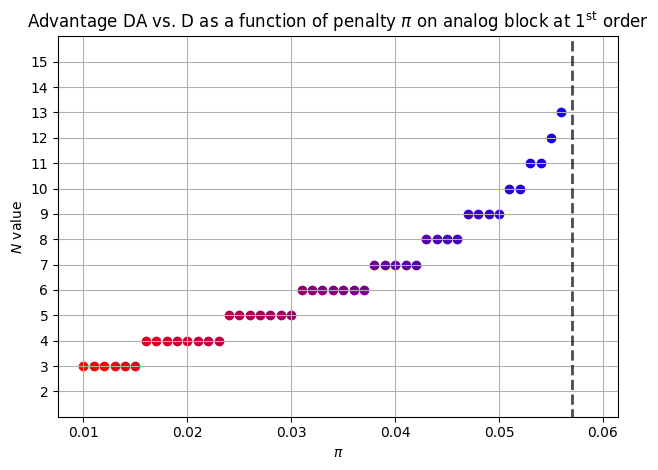

In [9]:
penalty_values = np.arange(10, 60) * 1e-3 

N_max = 15
values_N = np.arange(2, N_max+1)

if 0 in values_N or N_max <= 0: raise Exception("The choose values of N are not valid.")

values_N_advantage = []
idx_fail = MAX

for penalty in penalty_values:

    params = {
        # fidelities
        "F_1q": 1-1e-3, # fidelity of 1q rotations gates
        "F_Uq": 1-1e-3, # fidelity of Uq gates
        "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
        "F_xy": lambda N: 0.99 - penalty*(N-1), # fidelity of analog XY gate

        # number of gates per single Trotter step
        "N1D" : lambda N: 3*N*(N-1)/2 + N,
        "N1DA": lambda N: 4*N + N,       
        "NUq" : lambda N: 6*N*(N-1),
        "Nzz" : lambda N: 3*N*(N-1)/2,
        "Nxy" : 3
    }

    _, _, fidelityRatio = fidelityEvaluatorT1(values_N, params)

    idx_max = MAX

    for i, value in enumerate(fidelityRatio): 
        if value >= 1 and idx_max > i: 
            values_N_advantage.append(i + values_N[0])
            idx_max = i

    if idx_max == MAX: values_N_advantage.append(-1)
    
fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(penalty_values))      

for i, penalty in enumerate(penalty_values): ax.scatter(penalty, values_N_advantage[i], color=colors[i])

ax.set_title(r"Advantage DA vs. D as a function of penalty $\pi$ on analog block at $1^\text{st}$ order")
ax.set_xlabel(r"$\pi$")
ax.set_ylabel(r"$N$ value")
ax.set_yticks(values_N)
ax.set_ylim((values_N[0]-1, values_N[-1]+1))

# if idx_fail != MAX:
#     x_pt = np.array([penalty_values[idx_fail],penalty_values[idx_fail]])
#     y_pt = np.array([1.9,values_N[-1]])
#     plt.plot(x_pt, y_pt, 'r-', linewidth=3, alpha=0.7)

x_pt = np.array([0.057,0.057])
y_pt = np.array([0.9,values_N[-1]+1])
plt.plot(x_pt, y_pt, '--', linewidth=2, alpha=0.7, color="#000000")

plt.grid()
plt.tight_layout()
plt.show()

## Perfect 1 qubit gates analysis
We assume perfect single qubit gates with unit fidelity and imperfect multiple qubit gates.
1. given an analog block with fidelity described by some model, at what $N$ I win over digital?
2. given N, what analog block fidelity I need to win over digital?

In a single step of the algorithm:
- digital: $(N(N-1)/2)\times 3$ entangling gates (proved and can stay general, do not assume a particular decomposition)
- analog: $3$ analog gates indipendently of $N$.

### Answer to 1.

In [70]:
def fidDT1(N, args):
    return (args["F_zz"] ** args["Nzz"](N))

def fidDAT1(N, args):
    return (args["F_xy"] ** args["Nxy"])

def color_gradient(start, end, n):
    """Generate n hex colors from start to end."""
    start_rgb = np.array(mcolors.to_rgb(start))
    end_rgb = np.array(mcolors.to_rgb(end))
    return [mcolors.to_hex(start_rgb + (end_rgb - start_rgb) * i/(n-1)) for i in range(n)]

#### $F_{xy} = const$ model

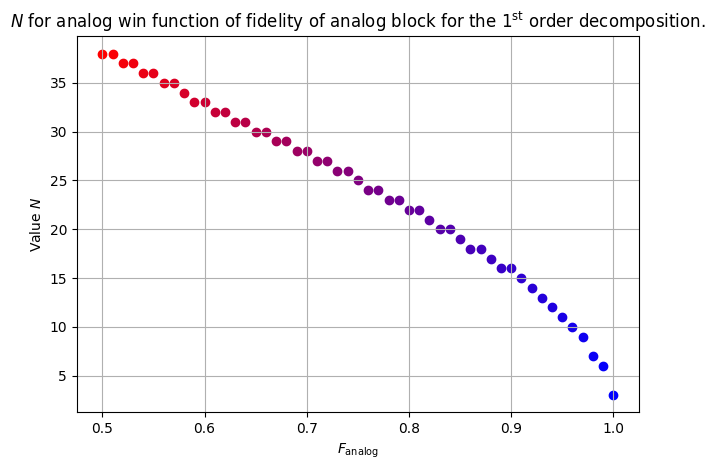

In [ ]:
#N_max = 50
#values_N = np.arange(2, N_max+1)
#
#fig, ax = plt.subplots()
#colors = color_gradient("#ff0000", "#0000ff", N_max-1)
#
#fid_digital = np.zeros(len(values_N))
#fid_danalog = np.zeros(len(values_N))
#
#for N in values_N:
#    fid_digital[N-2] = fidDT1(N, params)
#    fid_danalog[N-2] = fidDAT1(N, params)
#
#ax.scatter(values_N, fid_danalog, label="DAnalog", color="#C70E0E")
#ax.scatter(values_N, fid_digital, label="Digital", color="#0346FF")
#
#ax.set_title("Compare fidelities of digital and digital-analog approach.")
#ax.set_xlabel("N")
#ax.set_ylabel(r"$\mathcal{F}(N)$")
#
#legend = ax.legend(loc=1, frameon=True, borderaxespad=0.8, fontsize=6)
#legend.get_frame().set_facecolor('white')
#legend.get_frame().set_alpha(1.0)
#legend.get_frame().set_boxstyle("Square")
#
#plt.grid()
#plt.tight_layout()
#plt.show()

analog_fidelity_values = np.arange(0.5, 1.01, 0.01)
N_max = 50
values_N = np.arange(3, N_max+1)

if 0 in values_N or N_max <= 3: raise Exception("The choosen values of N are not valid.")

values_N_advantage = []
idx_fail = MAX

for fid in analog_fidelity_values:

    params = {
    # fidelities
    "F_zz": 1-1e-3,  # fidelity of 2 qubit ZZ gates
    "F_xy": fid, # fidelity of analog XY gate

    "Nzz" : lambda N: 3*N*(N-1)/2,
    "Nxy" : 3
    }

    fidelityRatios = [fidDAT1(N, params) / fidDT1(N, params) for N in values_N]

    idx_max = MAX

    for i, value in enumerate(fidelityRatios): 
        if value >= 1 and idx_max > i: 
            values_N_advantage.append(i + values_N[0])
            idx_max = i

    if idx_max == MAX: values_N_advantage.append(-1)
    
fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(analog_fidelity_values))      

for i, fidelity in enumerate(analog_fidelity_values): ax.scatter(fidelity, values_N_advantage[i], color=colors[i])

ax.set_title(r"$N$ for analog win function of fidelity of analog block for the $1^\text{st}$ order decomposition.")
ax.set_xlabel(r"$F_\text{analog}$")
ax.set_ylabel(r"Value $N$")

# if idx_fail != MAX:
#     x_pt = np.array([penalty_values[idx_fail],penalty_values[idx_fail]])
#     y_pt = np.array([1.9,values_N[-1]])
#     plt.plot(x_pt, y_pt, 'r-', linewidth=3, alpha=0.7)

plt.grid()
plt.tight_layout()
plt.show()

### Answer to 2.

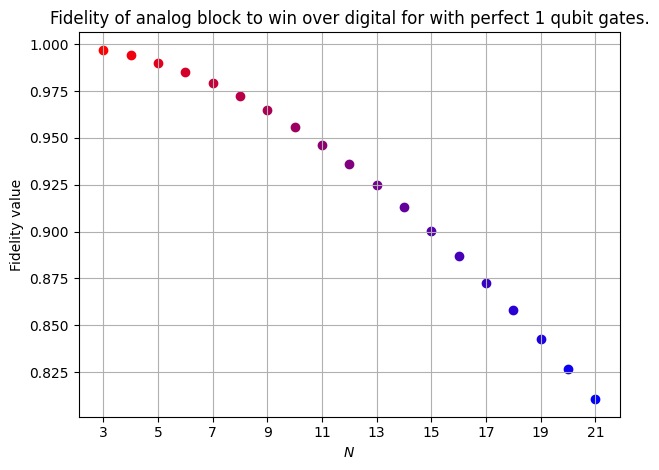

In [87]:
twoq_fidelity_values = np.array([0.999]) # do for a few different fidelity values of the 2 qubit operators
N_max = 21 # keep odd 
values_N = np.arange(3, N_max+1)

if 0 in values_N or N_max <= 3: raise Exception("The choosen values of N are not valid.")

fidelity_analog_win = []

for N in values_N: fidelity_analog_win.append(twoq_fidelity_values ** (N*(N-1)/2))

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(values_N))      

for i, N in enumerate(values_N): ax.scatter(N, fidelity_analog_win[i], color=colors[i])

ax.set_title(r"Fidelity of analog block to win over digital for with perfect 1 qubit gates.")
ax.set_xlabel(r"$N$")
ax.set_ylabel("Fidelity value")
ax.set_xticks(values_N[::2])

plt.grid()
plt.tight_layout()
plt.show()

## Imperfect 1 qubit gates analysis
We now also take into account imperfections of the single qubit operators. Again, we ask.
1. given an analog block with fidelity described by some model, at what $N$ I win over digital?
2. given N, what analog block fidelity I need to win over digital?

In a single step of the algorithm:
- digital: $(N(N-1)/2)\times 3$ entangling gates (proved and can stay general, do not assume a particular decomposition) and a number of one qubit gates that depends on the decomposition/hardware
- analog: $3$ analog gates indipendently of $N$ and $4N$ one qubit gates.


In [67]:
def fidDT1full(N, args):
    return (args["F_1q"] ** args["N1D"](N)) * (args["F_Uq"] ** args["NUq"](N)) * (args["F_zz"] ** args["Nzz"](N))

def fidDAT1full(N, args):
    return (args["F_1q"] ** args["N1DA"](N)) * (args["F_xy"](N) ** args["Nxy"])

### Answer to 1.

#### $F_{xy}=const$ model

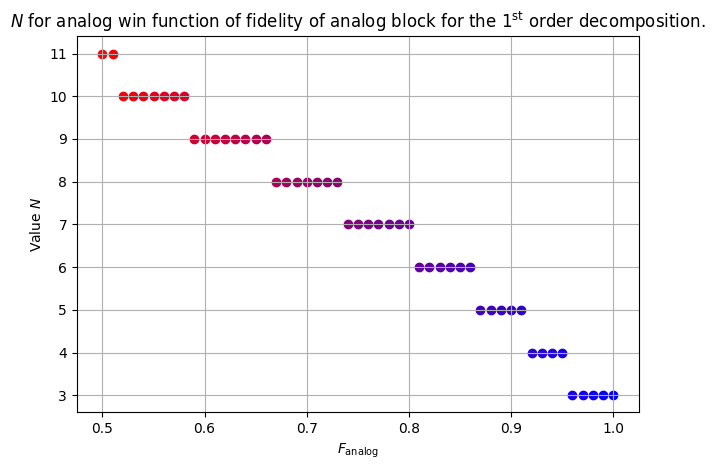

In [68]:
#N_max = 50
#values_N = np.arange(2, N_max+1)
#
#fig, ax = plt.subplots()
#colors = color_gradient("#ff0000", "#0000ff", N_max-1)
#
#fid_digital = np.zeros(len(values_N))
#fid_danalog = np.zeros(len(values_N))
#
#for N in values_N:
#    fid_digital[N-2] = fidDT1(N, params)
#    fid_danalog[N-2] = fidDAT1(N, params)
#
#ax.scatter(values_N, fid_danalog, label="DAnalog", color="#C70E0E")
#ax.scatter(values_N, fid_digital, label="Digital", color="#0346FF")
#
#ax.set_title("Compare fidelities of digital and digital-analog approach.")
#ax.set_xlabel("N")
#ax.set_ylabel(r"$\mathcal{F}(N)$")
#
#legend = ax.legend(loc=1, frameon=True, borderaxespad=0.8, fontsize=6)
#legend.get_frame().set_facecolor('white')
#legend.get_frame().set_alpha(1.0)
#legend.get_frame().set_boxstyle("Square")
#
#plt.grid()
#plt.tight_layout()
#plt.show()

analog_fidelity_values = np.arange(0.5, 1.01, 0.01)
N_max = 50
values_N = np.arange(3, N_max+1)

if 0 in values_N or N_max <= 3: raise Exception("The choosen values of N are not valid.")

values_N_advantage = []
idx_fail = MAX

for fid in analog_fidelity_values:

    params = {
    # fidelities
    "F_1q": 1-1e-3, # fidelity of 1q rotations gates
    "F_Uq": 1-1e-3, # fidelity of Uq gates
    "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
    "F_xy": lambda N: fid, # fidelity of analog XY gate
    # number of gates per single Trotter step
    "N1D" : lambda N: 3*N*(N-1)/2 + N,
    "N1DA": lambda N: 4*N + N,       
    "NUq" : lambda N: 6*N*(N-1),
    "Nzz" : lambda N: 3*N*(N-1)/2,
    "Nxy" : 3
    }

    fidelityRatios = [fidDAT1full(N, params) / fidDT1full(N, params) for N in values_N]

    idx_max = MAX

    for i, value in enumerate(fidelityRatios): 
        if value >= 1 and idx_max > i: 
            values_N_advantage.append(i + values_N[0])
            idx_max = i

    if idx_max == MAX: values_N_advantage.append(-1)
    
fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(analog_fidelity_values))      

for i, fidelity in enumerate(analog_fidelity_values): ax.scatter(fidelity, values_N_advantage[i], color=colors[i])

ax.set_title(r"$N$ for analog win function of fidelity of analog block for the $1^\text{st}$ order decomposition.")
ax.set_xlabel(r"$F_\text{analog}$")
ax.set_ylabel(r"Value $N$")

# if idx_fail != MAX:
#     x_pt = np.array([penalty_values[idx_fail],penalty_values[idx_fail]])
#     y_pt = np.array([1.9,values_N[-1]])
#     plt.plot(x_pt, y_pt, 'r-', linewidth=3, alpha=0.7)

plt.grid()
plt.tight_layout()
plt.show()

### Answer to 2.
I have to assume number of one qubit gates in the decomposition of the single step. I do for 3 to 10 (where 10 is the actual value for reference digital approach) 

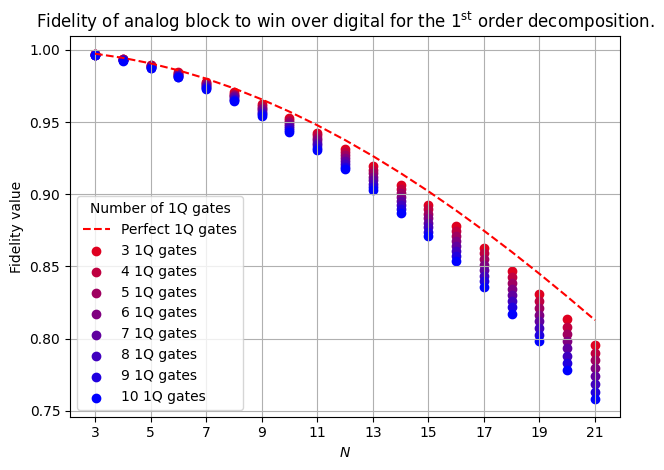

In [88]:
oneq_fid = 1 - 1e-4
twoq_fid = 1 - 1e-3
num_oneq_gates = np.concatenate(([0], np.arange(3, 11)))

N_max = 21  # keep odd
values_N = np.arange(3, N_max + 1)

if 0 in values_N or N_max <= 3:
    raise Exception("The chosen values of N are not valid.")

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(num_oneq_gates))

for i, oneq in enumerate(num_oneq_gates):
    fidelity_analog_win = (
        oneq_fid ** ((oneq * values_N**2 - values_N * (oneq + 8)) / 6)
        * twoq_fid ** (values_N * (values_N - 1) / 2)
    )
    if oneq == 0:
        ax.plot(values_N, fidelity_analog_win, "--", color=colors[i], label="Perfect 1Q gates")
    else:
        ax.scatter(values_N, fidelity_analog_win, color=colors[i], label=f"{oneq} 1Q gates")

ax.set_title(r"Fidelity of analog block to win over digital for the $1^\text{st}$ order decomposition.")
ax.set_xlabel(r"$N$")
ax.set_ylabel("Fidelity value")
ax.set_xticks(values_N[::2])

ax.legend(title="Number of 1Q gates", loc=3)
plt.grid()
plt.tight_layout()
plt.show()